# Basic stock price prediction using LSTM

This is a notebook showcasing the incapabilities of predicting stock prices using an LSTM.

The model uses a sliding window technique, where values from the last 50 days are being fed into the LSTM model and it predicts stock price for the next day.

This notebook highlights the shortcomings of this approach and later focuses on recursive predictions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
# Load the .pkl file
df = pd.read_pickle("historical_prices.pkl")

# Extract the desired column and convert it to a numpy array
ticker = "AMZN"
df = df[ticker].values

# Reshape if necessary (similar to how it was done with the CSV)
df = df.reshape(-1, 1)

# Display the extracted values
print(df.shape)
print(df)


[[ 16.15250015]
 [ 16.24650002]
 [ 16.32699966]
 ...
 [206.83999634]
 [208.91000366]
 [214.1000061 ]]


In [ ]:
# Assume df is already defined and its shape is (2516, 1)

# Create a copy of df
df_all_copy = df.copy()

# Modify df to exclude the last 50 values
df = df[:-50]

# Display the shapes to confirm
print("Shape of df_all_copy:", df_all_copy.shape)
print("Shape of modified df:", df.shape)

Shape of df_all_copy: (2515, 1)
Shape of modified df: (2465, 1)


In [ ]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

When we test or predict using dataset_test (the last 20% + 50 overlap), the model uses the sequences in the test set to predict the next day.
For each prediction, the model takes a 50-day sequence from the test data and predicts the next day (y_test).

In [ ]:
dataset_test.shape

(543, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:7]

array([[0.0104806 ],
       [0.0110264 ],
       [0.01149382],
       [0.01265511],
       [0.01326188],
       [0.01413574],
       [0.01396156]])

In [ ]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:7]

array([[0.58756672],
       [0.56556036],
       [0.55087011],
       [0.5577217 ],
       [0.55905715],
       [0.57601195],
       [0.57723129]])

In [ ]:
def create_my_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

Sliding Window Mechanism:

The model moves a sliding window of 50 days across the test data, which means each prediction is based on the 50 most recent days from the actual data.

In [ ]:
x_train,y_train = create_my_dataset(dataset_train)
x_train[:1]

array([[0.0104806 , 0.0110264 , 0.01149382, 0.01265511, 0.01326188,
        0.01413574, 0.01396156, 0.01353477, 0.0150067 , 0.01133704,
        0.01142705, 0.00857899, 0.00870384, 0.00745545, 0.00571643,
        0.00741771, 0.00548417, 0.00592546, 0.00591385, 0.00555094,
        0.00235451, 0.00346354, 0.00312967, 0.00375966, 0.00568739,
        0.00561481, 0.00466837, 0.00642772, 0.00728416, 0.006779  ,
        0.00679352, 0.00626223, 0.0044245 , 0.00242128, 0.00332998,
        0.00392224, 0.00289741, 0.00129484, 0.00226161, 0.00183483,
        0.        , 0.00110032, 0.0007229 , 0.00299031, 0.00678481,
        0.00738578, 0.0065932 , 0.00574836, 0.00492385, 0.00720868]])

In [ ]:
x_train[:1].shape

(1, 50)

In [ ]:
x_test,y_test = create_my_dataset(dataset_test)
x_test[:1]

array([[0.58756672, 0.56556036, 0.55087011, 0.5577217 , 0.55905715,
        0.57601195, 0.57723129, 0.60306987, 0.62954715, 0.64034711,
        0.62751491, 0.6200827 , 0.58332801, 0.61909561, 0.62670202,
        0.70026942, 0.70282426, 0.69568238, 0.72680483, 0.74451444,
        0.73423704, 0.72616612, 0.71699195, 0.74521118, 0.73330799,
        0.75020471, 0.74805628, 0.75734659, 0.74178541, 0.74294668,
        0.71931449, 0.69022433, 0.69254686, 0.69359206, 0.7137984 ,
        0.67588245, 0.67030824, 0.66415344, 0.65277286, 0.65886962,
        0.65706964, 0.64894064, 0.66850826, 0.67048252, 0.69051467,
        0.70897906, 0.65306319, 0.66310833, 0.64992772, 0.63396005]])

In [ ]:
#x_train.shape
#(957,50,1)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(1922, 50, 1)
(493, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=96,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,953 (726.38 KB)

 Trainable params: 185,953 (726.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [ ]:
if (not os.path.exists('stock_prediction.h5')):
    model.fit(x_train,y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.0413
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0026
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.0028
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0024
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - loss: 0.0029
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0023
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - loss: 0.0027
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0025
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0022
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 0.0036
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0019
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 0.0021
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0018
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0016
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/ste

In [ ]:
model = load_model('stock_prediction.h5')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step
range(1972, 2465)


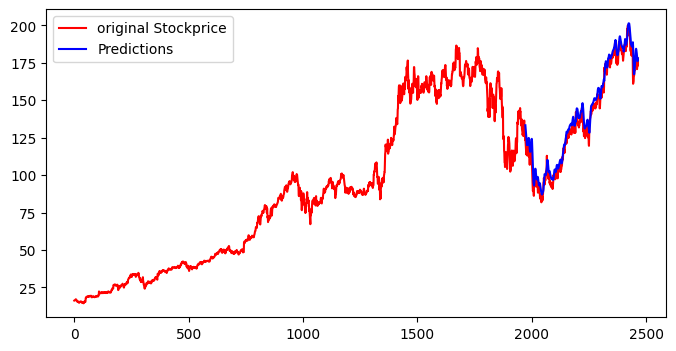

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig,ax = plt.subplots(figsize=(8,4))
plt.plot(df,color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions, color='blue',label='Predictions')
plt.legend()
print(range(len(y_train)+50,len(y_train)+50+len(predictions)))

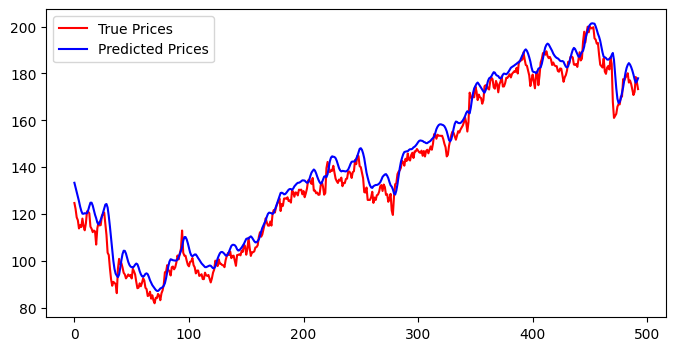

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red',label='True Prices')
plt.plot(predictions,color="blue",label = 'Predicted Prices')
plt.legend()

# Recursive predictions
The following code tries to predict the value of a stock for the following 50 days.

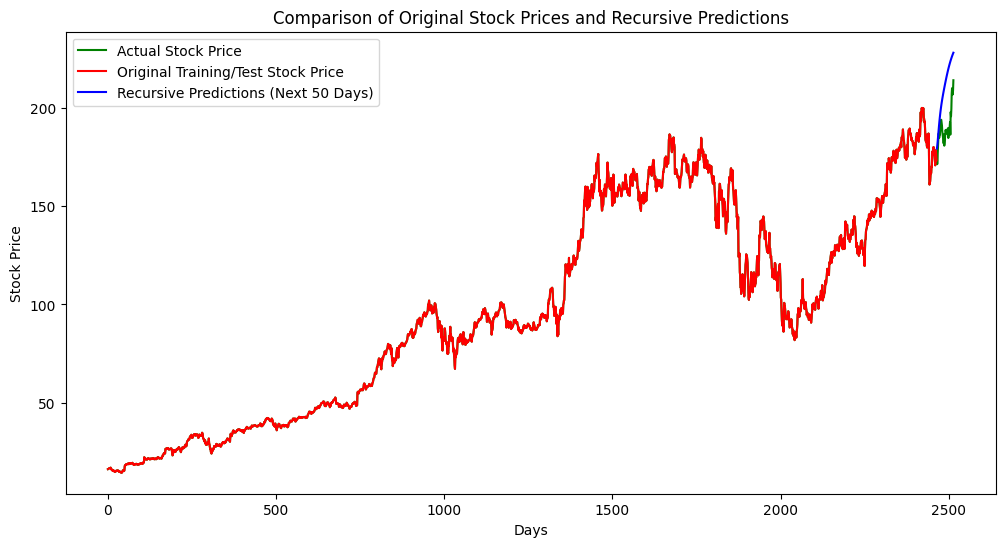

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the pre-trained model and data
model = load_model('stock_prediction.h5')

# Assume df_all_copy is already defined and has a shape of (2516, 1)
# Assume df is defined and has a shape of (2466, 1), without the last 50 values

# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define a function for recursive prediction for the next 50 days
def recursive_prediction(model, last_sequence, num_days):
    predictions = []
    current_input = last_sequence

    for _ in range(num_days):
        # Reshape to match the model's input shape (1, 50, 1)
        current_input = current_input.reshape(1, current_input.shape[0], 1)
        next_prediction = model.predict(current_input, verbose=0)

        # Store the prediction
        predictions.append(next_prediction[0, 0])

        # Update the input sequence: remove the oldest value and add the prediction
        current_input = np.append(current_input[0, 1:], next_prediction)

    # Reverse the scaling for the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions

# Use the last 50 days from df as the initial input for predictions
last_50_days = scaled_data[-50:]

# Predict the next 50 days recursively
predicted_future = recursive_prediction(model, last_50_days, 50)

# Plotting the results
plt.figure(figsize=(12, 6))
# Plot the full original data from df_all_copy
plt.plot(range(len(df_all_copy)), df_all_copy, color='green', label='Actual Stock Price')
# Highlight the section used in df (up to the end of training/testing)
plt.plot(range(len(df)), df, color='red', label='Original Training/Test Stock Price')
# Plot the recursive predictions for the next 50 days
plt.plot(range(len(df), len(df) + 50), predicted_future, color='blue', label='Recursive Predictions (Next 50 Days)')

plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Comparison of Original Stock Prices and Recursive Predictions')
plt.legend()
plt.show()


# Conclusion
It is not that simple to "predict" actual stock prices using an LSTM, which was probably assumed earlier. An LSTM model needs to be continuously fed with ACTUAL price data in order to be able to predict close values.

However, we get 2 main takeaways from this.

Firstly, our "prediction" is nothing more than a curve similar to the original data, but with a certain lag. That will help us neither with day-to-day trading nor with long investment trading.

In that case, we have 2 roads we can follow:

1. We could predict the change for the next day instead of an actual price.
2. We can try to capture a sort of trend in the data, which could help us with long-term investing. As we can see above, the model correctly evaluated the trend, however what happened was the change of momentum on the MSFT stock, as it dynamically went up.